# Girona Kale distribution

A new company looks for potential buyers (restautants and supermarkets) for a new and healthy product. The production and process plant will be placed in Girona (Spain) surrounders. The principals objectives are:

+ Look for the best place for an office in Girona city
+ List for a potencial buyers (Restaurants and supermarkets)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
#Import the url

url = "https://es.wikipedia.org/wiki/Gerona"
html = urlopen(url)

soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

## Data scrapping

First of allwe need to collect our data, "Barrios" and "Sectors" of Girona city. We have the URL with a data table (above) and now we can extract the information.

In [273]:
#Get the rows of the data table
rows = soup.find_all('tr')

import re

list_rows = []
for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',str_cells))
    list_rows.append(clean2)

df = pd.DataFrame(list_rows)

#Select our interest rows
df = df.iloc[50:59,]

#Clean Data
df1[0] = df[0].str.strip('[ ] \n')
df1 = df1[0].str.split(',', expand=True)
df1[0] = df1[0].str.strip('\n')

new1 = df1[2].copy() 
new2 = df1[3].copy() 
new3 = df1[4].copy() 
new4 = df1[5].copy() 
  
na_string ="None"

df1[1]= df1[1].str.cat(new1, sep =", ", na_rep = na_string) 
df1[1]= df1[1].str.cat(new2, sep =", ", na_rep = na_string) 
df1[1]= df1[1].str.cat(new3, sep =", ", na_rep = na_string) 
df1[1]= df1[1].str.cat(new4, sep =", ", na_rep = na_string) 

col = range(2,6)
df1 = df1.drop(col, axis = 1)

df1[1] = df1[1].str.strip('None, ')
df1[1] = df1[1].str.replace('y ', ', ')

#Display final table
df1

,0,1
50,Centre,"Barri Vell, Mercadal , Carm"
51,Eixample,"Sant Narcís, Eixample Nord , Eixample Sud"
52,Est,"Sant Daniel, Torre Gironella, Pedreres, Fon..."
53,Mas Xirgu,Mas Xirgu
54,Montjuïc,Montjuïc
55,Nord,"Pedret, Pont Major, Muntanya de Campdorà , P..."
56,Oest,"Sant Ponç, Fontajau, Taialà, Germans Sàbat,..."
57,Santa Eugènia,"Hortes, Santa Eugènia , Can Gibert"
58,Sud,"Palau, l'Avellaneda, Montilivi , la Creueta"


Now the data is clean, we can proceed to export our labels (index)

In [274]:
#To obtain columns labels

col_labels = soup.find_all('th')

all_header = []
col_str = str(col_labels)
cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
all_header.append(cleantext2)

df2 = pd.DataFrame(all_header)
df2
df3 = df2[0].str.split(',', expand=True)
col = range(0,46)
col2 = range(48,53)
df3 = df3.drop(col, axis = 1)
df3 = df3.drop(col2, axis = 1)
df3[46] = df3[46].str.strip('\n')
df3[47] = df3[47].str.strip('\n')
df3.columns = range(df3.shape[1])

frames = [df3, df1]

df4 = pd.concat(frames)

#Include names and erase all rows with NA

df5 = df4.rename(columns=df4.iloc[0])
df6 = df5.dropna(axis=0, how='any')
df7 = df6.drop(df6.index[0])

df7.rename(columns={" Barrio": "Barrio", ' Sectores':'Sectores' }, inplace=True)
df7.Barrio = df7.Barrio + ', Girona'

df7["Barrio"] = df7["Barrio"].str.replace('Est', 'Sant Daniel')
df7["Barrio"] = df7["Barrio"].str.replace('Nord', 'Pla de Campdorà')
df7["Barrio"] = df7["Barrio"].str.replace('Oest', 'Sant Ponç')
df7["Barrio"] = df7["Barrio"].str.replace('Sud', 'Montilivi')
df7["Barrio"] = df7["Barrio"].str.replace('Eixample', 'Sant Narcís')

df7


,Barrio,Sectores
50,"Centre, Girona","Barri Vell, Mercadal , Carm"
51,"Sant Narcís, Girona","Sant Narcís, Eixample Nord , Eixample Sud"
52,"Sant Daniel, Girona","Sant Daniel, Torre Gironella, Pedreres, Fon..."
53,"Mas Xirgu, Girona",Mas Xirgu
54,"Montjuïc, Girona",Montjuïc
55,"Pla de Campdorà, Girona","Pedret, Pont Major, Muntanya de Campdorà , P..."
56,"Sant Ponç, Girona","Sant Ponç, Fontajau, Taialà, Germans Sàbat,..."
57,"Santa Eugènia, Girona","Hortes, Santa Eugènia , Can Gibert"
58,"Montilivi, Girona","Palau, l'Avellaneda, Montilivi , la Creueta"


In [275]:
#GeocodeFarm, GeoNames, GoogleV3, ny_explorer :: user_agents

#!conda install -c conda-forge geopandas
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode("Girona, Spain")

print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 41.9793006, Longitude = 2.8199439


In [276]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# 2- - create location column
df7['location'] = df7['Barrio'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df7['point'] = df7['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df7[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df7['point'].tolist(), index=df7.index)
# 5 - drop all columns inecessaries
df7 = df7.drop(["location", "point", "altitude"], axis=1)

dfDA = df7
df7


,Barrio,Sectores,latitude,longitude
50,"Centre, Girona","Barri Vell, Mercadal , Carm",41.979301,2.819944
51,"Sant Narcís, Girona","Sant Narcís, Eixample Nord , Eixample Sud",41.974247,2.811085
52,"Sant Daniel, Girona","Sant Daniel, Torre Gironella, Pedreres, Fon...",42.002908,2.848043
53,"Mas Xirgu, Girona",Mas Xirgu,41.960412,2.804262
54,"Montjuïc, Girona",Montjuïc,41.994913,2.833146
55,"Pla de Campdorà, Girona","Pedret, Pont Major, Muntanya de Campdorà , P...",42.025089,2.833761
56,"Sant Ponç, Girona","Sant Ponç, Fontajau, Taialà, Germans Sàbat,...",41.996909,2.821115
57,"Santa Eugènia, Girona","Hortes, Santa Eugènia , Can Gibert",41.977527,2.807016
58,"Montilivi, Girona","Palau, l'Avellaneda, Montilivi , la Creueta",41.970379,2.831247


In [277]:
import folium

address = 'Girona, Spain'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Girona are {}, {}.'.format(latitude, longitude))

map_girona = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Barrio, Sectores in zip(df7['latitude'], df7['longitude'], df7['Barrio'], df7['Sectores']):
    label = '{}, {}'.format(Sectores, Barrio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_girona)  
    
map_girona

The geograpical coordinate of Girona are 41.9793006, 2.8199439.


In [278]:
# Define credentials

CLIENT_ID = 'EMYBPS0CGGFMMDSJVREFWST431MBGFPA4GZ1ZIVJTD4XVGXH' # your Foursquare ID
CLIENT_SECRET = '43TZ4UXGCWY0JVOR3PIK5D3KOO4SRD3ME4A2AYUZHHYD5LVD' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: EMYBPS0CGGFMMDSJVREFWST431MBGFPA4GZ1ZIVJTD4XVGXH
CLIENT_SECRET:43TZ4UXGCWY0JVOR3PIK5D3KOO4SRD3ME4A2AYUZHHYD5LVD


In [279]:
#Obtain venues of all Neighborhoods
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Barrio', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Look venues for Barrio's

In [280]:


LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

girona_venues = getNearbyVenues(names=df7['Barrio'],
                                   latitudes=df7['latitude'],
                                   longitudes=df7['longitude']
                                  )

Centre, Girona
Sant Narcís, Girona
Sant Daniel, Girona
Mas Xirgu, Girona
Montjuïc, Girona
Pla de Campdorà, Girona
Sant Ponç, Girona
Santa Eugènia, Girona
Montilivi, Girona


In [282]:
print(girona_venues.shape)
girona_venues.head()
df7 = girona_venues
df7

(92, 7)


,Barrio,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Centre, Girona",41.979301,2.819944,Pizzeria La Pulcinella,41.978223,2.821999,Pizza Place
1,"Centre, Girona",41.979301,2.819944,Mercat del Lleó,41.979580,2.822816,Market
2,"Centre, Girona",41.979301,2.819944,Llagurt,41.977369,2.821059,Ice Cream Shop
3,"Centre, Girona",41.979301,2.819944,Indigo,41.978604,2.820871,Paella Restaurant
4,"Centre, Girona",41.979301,2.819944,Plaça de Catalunya,41.981658,2.823331,Plaza
...,...,...,...,...,...,...,...
87,"Santa Eugènia, Girona",41.977527,2.807016,Xurreria el Sol,41.975048,2.805118,Food Truck
88,"Santa Eugènia, Girona",41.977527,2.807016,Cafe Quiósc Delgado,41.977669,2.812562,Café
89,"Santa Eugènia, Girona",41.977527,2.807016,Pizzeria Bella Napoli,41.979961,2.811697,Pizza Place
90,"Santa Eugènia, Girona",41.977527,2.807016,Parque,41.977115,2.801106,Park


In [283]:
address = 'Girona, Spain'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Girona are {}, {}.'.format(latitude, longitude))

map_girona = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Barrio, Sectores in zip(df7['Venue Latitude'], df7['Venue Longitude'], df7['Venue Category'], df7['Venue']):
    label = '{}, {}'.format(Sectores, Barrio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_girona)  
    
map_girona

The geograpical coordinate of Girona are 41.9793006, 2.8199439.


## Analysis of Barrio's venues

In [284]:
#Neighborhood analisys

# one hot encoding
girona_onehot = pd.get_dummies(girona_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
girona_onehot['Barrio'] = girona_venues['Barrio'] 

# move neighborhood column to the first column
fixed_columns = [girona_onehot.columns[-1]] + list(girona_onehot.columns[:-1])
girona_onehot = girona_onehot[fixed_columns]

girona_grouped = girona_onehot.groupby('Barrio').mean().reset_index()
girona_grouped

#Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in girona_grouped['Barrio']:
    print("----"+hood+"----")
    temp = girona_grouped[girona_grouped['Barrio'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
num_top_venues = 5

#Let's put that into a pandas dataframe
#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Barrio']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Barrio'] = girona_grouped['Barrio']

for ind in np.arange(girona_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(girona_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(9)

----Centre, Girona----
                 venue  freq
0                Plaza  0.08
1               Bakery  0.06
2        Train Station  0.06
3       Ice Cream Shop  0.06
4  Japanese Restaurant  0.06


----Mas Xirgu, Girona----
             venue  freq
0  Auto Dealership  0.25
1       Restaurant  0.12
2      Supermarket  0.12
3    Shopping Mall  0.12
4     Burger Joint  0.12


----Montilivi, Girona----
                      venue  freq
0                       Bar   1.0
1        Athletics & Sports   0.0
2               Record Shop   0.0
3                    Market   0.0
4  Mediterranean Restaurant   0.0


----Montjuïc, Girona----
             venue  freq
0  Bed & Breakfast   0.2
1     Soccer Field   0.2
2      Snack Place   0.2
3           Garden   0.2
4       Playground   0.2


----Pla de Campdorà, Girona----
                venue  freq
0             Dog Run   0.5
1          Restaurant   0.5
2  Athletics & Sports   0.0
3                 Pub   0.0
4              Market   0.0


----Sant Dan

,Barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Centre, Girona",Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
1,"Mas Xirgu, Girona",Auto Dealership,Burger Joint,Supermarket,Shopping Mall,Electronics Store,Restaurant,Café,Cafeteria,Garden,Fried Chicken Joint
2,"Montilivi, Girona",Bar,Wine Bar,Café,Gift Shop,Gastropub,Garden,Fried Chicken Joint,Food Truck,Electronics Store,Dog Run
3,"Montjuïc, Girona",Garden,Soccer Field,Snack Place,Bed & Breakfast,Playground,Wine Bar,Cafeteria,Fried Chicken Joint,Food Truck,Electronics Store
4,"Pla de Campdorà, Girona",Dog Run,Restaurant,Wine Bar,Cafeteria,Gastropub,Garden,Fried Chicken Joint,Food Truck,Electronics Store,Dessert Shop
5,"Sant Daniel, Girona",Restaurant,Wine Bar,Cafeteria,Gastropub,Garden,Fried Chicken Joint,Food Truck,Electronics Store,Dog Run,Dessert Shop
6,"Sant Narcís, Girona",Gym,Supermarket,Café,Plaza,Athletics & Sports,Record Shop,Hotel,Department Store,Cafeteria,Gift Shop
7,"Sant Ponç, Girona",Hotel,Gym Pool,Sandwich Place,Fried Chicken Joint,Mediterranean Restaurant,Plaza,Restaurant,Burger Joint,Supermarket,Beer Garden
8,"Santa Eugènia, Girona",Supermarket,Café,Cafeteria,Shoe Store,Food Truck,Mediterranean Restaurant,Park,Pizza Place,Gift Shop,Bar


In [285]:
from sklearn.cluster import KMeans
#Cluster Neighborhoods
#Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 3

girona_grouped_clustering = girona_grouped.drop('Barrio', 1)

# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(girona_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

girona_merged = df7

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
girona_merged = girona_merged.join(neighborhoods_venues_sorted.set_index('Barrio'), on='Barrio')

girona_merged['Cluster Labels'] = girona_merged['Cluster Labels'].fillna(0).astype(np.int64)
#toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype("int")

girona_merged.head(10) # check the last columns!

,Barrio,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Centre, Girona",41.979301,2.819944,Pizzeria La Pulcinella,41.978223,2.821999,Pizza Place,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
1,"Centre, Girona",41.979301,2.819944,Mercat del Lleó,41.979580,2.822816,Market,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
2,"Centre, Girona",41.979301,2.819944,Llagurt,41.977369,2.821059,Ice Cream Shop,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
3,"Centre, Girona",41.979301,2.819944,Indigo,41.978604,2.820871,Paella Restaurant,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
4,"Centre, Girona",41.979301,2.819944,Plaça de Catalunya,41.981658,2.823331,Plaza,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
5,"Centre, Girona",41.979301,2.819944,Escondido Cafè,41.977773,2.822520,Mexican Restaurant,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
6,"Centre, Girona",41.979301,2.819944,König,41.977193,2.821080,Burger Joint,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
7,"Centre, Girona",41.979301,2.819944,Umai,41.983094,2.821719,Japanese Restaurant,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
8,"Centre, Girona",41.979301,2.819944,La Gioconda,41.981722,2.823458,Ice Cream Shop,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel
9,"Centre, Girona",41.979301,2.819944,Hotel Carlemany,41.978615,2.820819,Hotel,0,Plaza,Train Station,Japanese Restaurant,Burger Joint,Bakery,Ice Cream Shop,Wine Bar,Mediterranean Restaurant,Market,Hotel


In [286]:
#Mapping

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(girona_merged['Neighborhood Latitude'], girona_merged['Neighborhood Longitude'], girona_merged['Barrio'], girona_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis by Sector

Separated by sectors

In [371]:
dfDA2 = dfDA.drop(["latitude","longitude"], axis=1)

dfDA2
#girona_data = dfDA[dfDA['Barrio'] == 'Centre, Girona'].reset_index(drop=True)
#girona_data.head()


,Barrio,Sectores
50,"Centre, Girona","Barri Vell, Mercadal , Carm"
51,"Sant Narcís, Girona","Sant Narcís, Eixample Nord , Eixample Sud"
52,"Sant Daniel, Girona","Sant Daniel, Torre Gironella, Pedreres, Fon..."
53,"Mas Xirgu, Girona",Mas Xirgu
54,"Montjuïc, Girona",Montjuïc
55,"Pla de Campdorà, Girona","Pedret, Pont Major, Muntanya de Campdorà , P..."
56,"Sant Ponç, Girona","Sant Ponç, Fontajau, Taialà, Germans Sàbat,..."
57,"Santa Eugènia, Girona","Hortes, Santa Eugènia , Can Gibert"
58,"Montilivi, Girona","Palau, l'Avellaneda, Montilivi , la Creueta"


In [372]:
dfDA2 = (dfDA2.set_index(['Barrio'])
   .apply(lambda x: x.str.split(',').explode())
   .reset_index())

dfDA2.Sectores = dfDA2.Sectores + ', Girona'

dfDA2

,Barrio,Sectores
0,"Centre, Girona","Barri Vell, Girona"
1,"Centre, Girona","Mercadal , Girona"
2,"Centre, Girona","Carm, Girona"
3,"Sant Narcís, Girona","Sant Narcís, Girona"
4,"Sant Narcís, Girona","Eixample Nord , Girona"
5,"Sant Narcís, Girona","Eixample Sud, Girona"
6,"Sant Daniel, Girona","Sant Daniel, Girona"
7,"Sant Daniel, Girona","Torre Gironella, Girona"
8,"Sant Daniel, Girona","Pedreres, Girona"
9,"Sant Daniel, Girona","Font de la Pólvora, Girona"


In [373]:
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# 2- - create location column
dfDA2['location'] = dfDA2['Sectores'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dfDA2['point'] = dfDA2['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
dfDA2[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dfDA2['point'].tolist(), index=dfDA2.index)
# 5 - drop all columns inecessaries
dfDA2 = dfDA2.drop(["location", "point", "altitude"], axis=1)

dfDA3 = dfDA2
dfDA3

,Barrio,Sectores,latitude,longitude
0,"Centre, Girona","Barri Vell, Girona",41.985607,2.826943
1,"Centre, Girona","Mercadal , Girona",41.982574,2.821633
2,"Centre, Girona","Carm, Girona",NaN,NaN
3,"Sant Narcís, Girona","Sant Narcís, Girona",41.974247,2.811085
4,"Sant Narcís, Girona","Eixample Nord , Girona",41.984798,2.822944
5,"Sant Narcís, Girona","Eixample Sud, Girona",NaN,NaN
6,"Sant Daniel, Girona","Sant Daniel, Girona",42.002908,2.848043
7,"Sant Daniel, Girona","Torre Gironella, Girona",41.986599,2.829425
8,"Sant Daniel, Girona","Pedreres, Girona",42.103732,2.772563
9,"Sant Daniel, Girona","Font de la Pólvora, Girona",41.975515,2.841379


In [374]:
dfDA3 = dfDA3.drop([8, 14, 15, 23, 26, 29, 30])

dfDA3 = dfDA3.dropna()
dfDA3



,Barrio,Sectores,latitude,longitude
0,"Centre, Girona","Barri Vell, Girona",41.985607,2.826943
1,"Centre, Girona","Mercadal , Girona",41.982574,2.821633
3,"Sant Narcís, Girona","Sant Narcís, Girona",41.974247,2.811085
4,"Sant Narcís, Girona","Eixample Nord , Girona",41.984798,2.822944
6,"Sant Daniel, Girona","Sant Daniel, Girona",42.002908,2.848043
7,"Sant Daniel, Girona","Torre Gironella, Girona",41.986599,2.829425
9,"Sant Daniel, Girona","Font de la Pólvora, Girona",41.975515,2.841379
10,"Sant Daniel, Girona","Vila-roja , Girona",41.971551,2.844332
11,"Sant Daniel, Girona","Gavarres, Girona",42.178586,3.025573
12,"Mas Xirgu, Girona","Mas Xirgu, Girona",41.960412,2.804262


In [376]:


LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

girona_venues = getNearbyVenues(names=dfDA3['Sectores'],
                                   latitudes=dfDA3['latitude'],
                                   longitudes=dfDA3['longitude']
                                  )

Barri Vell, Girona
  Mercadal , Girona
Sant Narcís, Girona
  Eixample Nord , Girona
Sant Daniel, Girona
  Torre Gironella, Girona
  Font de la Pólvora, Girona
  Vila-roja , Girona
 Gavarres, Girona
Mas Xirgu, Girona
Montjuïc, Girona
  Pont Major, Girona
 Pla de Campdorà, Girona
Sant Ponç, Girona
  Fontajau, Girona
  Taialà, Girona
  Germans Sàbat, Girona
 Sud, Girona
  Santa Eugènia , Girona
 Can Gibert, Girona
  Montilivi , Girona
 la Creueta, Girona


In [377]:
print(girona_venues.shape)
girona_venues.head()
dfDA3 = girona_venues
dfDA3

(475, 7)


,Barrio,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Barri Vell, Girona",41.985607,2.826943,Muralla de Girona,41.986602,2.828390,Historic Site
1,"Barri Vell, Girona",41.985607,2.826943,Plaça de la Catedral,41.987312,2.825344,Plaza
2,"Barri Vell, Girona",41.985607,2.826943,Espresso Mafia,41.984764,2.825066,Café
3,"Barri Vell, Girona",41.985607,2.826943,La Fábrica,41.983910,2.825930,Café
4,"Barri Vell, Girona",41.985607,2.826943,Martina Sweet cakes,41.985454,2.825049,Pie Shop
...,...,...,...,...,...,...,...
470,"Montilivi , Girona",41.970379,2.831247,A 1/2 Camí,41.968896,2.826156,Bar
471,"la Creueta, Girona",41.969561,2.834068,Vilarroja,41.971175,2.838026,Stables
472,"la Creueta, Girona",41.969561,2.834068,El Ginjoler,41.967009,2.837020,Mediterranean Restaurant
473,"la Creueta, Girona",41.969561,2.834068,Restaurant Cafeteria Ictineu,41.967674,2.837839,Restaurant


In [378]:
address = 'Girona, Spain'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Girona are {}, {}.'.format(latitude, longitude))

map_girona = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Barrio, Sectores in zip(dfDA3['Venue Latitude'], dfDA3['Venue Longitude'], dfDA3['Venue Category'], dfDA3['Venue']):
    label = '{}, {}'.format(Sectores, Barrio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_girona)  
    
map_girona

The geograpical coordinate of Girona are 41.9793006, 2.8199439.


In [385]:
#Neighborhood analisys

# one hot encoding
girona_onehot = pd.get_dummies(girona_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
girona_onehot['Barrio'] = girona_venues['Barrio'] 

# move neighborhood column to the first column
fixed_columns = [girona_onehot.columns[-1]] + list(girona_onehot.columns[:-1])
girona_onehot = girona_onehot[fixed_columns]

girona_grouped = girona_onehot.groupby('Barrio').mean().reset_index()
girona_grouped

#Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in girona_grouped['Barrio']:
    print("----"+hood+"----")
    temp = girona_grouped[girona_grouped['Barrio'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
num_top_venues = 5

#Let's put that into a pandas dataframe
#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Barrio']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Barrio'] = girona_grouped['Barrio']

for ind in np.arange(girona_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(girona_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(30)

----  Eixample Nord , Girona----
                      venue  freq
0                     Plaza  0.08
1                Restaurant  0.07
2                      Café  0.07
3  Mediterranean Restaurant  0.06
4             Historic Site  0.04


----  Font de la Pólvora, Girona----
          venue  freq
0  Home Service   1.0
1     Multiplex   0.0
2         Plaza   0.0
3    Playground   0.0
4   Pizza Place   0.0


----  Fontajau, Girona----
                venue  freq
0         Supermarket  0.13
1      Sandwich Place  0.13
2  Spanish Restaurant  0.07
3        Burger Joint  0.07
4           Multiplex  0.07


----  Germans Sàbat, Girona----
                venue  freq
0            Pharmacy  0.33
1         Snack Place  0.33
2        Soccer Field  0.33
3  African Restaurant  0.00
4                Pool  0.00


----  Mercadal , Girona----
                      venue  freq
0  Mediterranean Restaurant  0.08
1                Restaurant  0.08
2                     Plaza  0.06
3        Spanish Restaurant

,Barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Eixample Nord , Girona",Plaza,Restaurant,Café,Mediterranean Restaurant,Hotel,Spanish Restaurant,Historic Site,Bar,Italian Restaurant,Wine Bar
1,"Font de la Pólvora, Girona",Home Service,Wine Shop,Donut Shop,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Creperie,Deli / Bodega
2,"Fontajau, Girona",Sandwich Place,Supermarket,Bar,Plaza,Multiplex,Spanish Restaurant,Sushi Restaurant,Asian Restaurant,Casino,Fried Chicken Joint
3,"Germans Sàbat, Girona",Soccer Field,Pharmacy,Snack Place,Wine Shop,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop
4,"Mercadal , Girona",Mediterranean Restaurant,Restaurant,Plaza,Spanish Restaurant,Pub,Hotel,Japanese Restaurant,Café,Wine Bar,Ice Cream Shop
5,"Montilivi , Girona",Bar,Donut Shop,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Creperie,Deli / Bodega,Department Store
6,"Pont Major, Girona",Restaurant,Wine Shop,Train Station,Business Service,Diner,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar
7,"Santa Eugènia , Girona",Supermarket,Café,Gift Shop,Park,Shoe Store,Mediterranean Restaurant,Pizza Place,Bar,Cafeteria,Food Truck
8,"Taialà, Girona",Mediterranean Restaurant,Pool,Park,Brazilian Restaurant,Dog Run,Diner,Playground,Deli / Bodega,Café,Casino
9,"Torre Gironella, Girona",Mediterranean Restaurant,Restaurant,Plaza,Historic Site,Café,Cocktail Bar,Ice Cream Shop,History Museum,Spanish Restaurant,Garden


In [386]:
from sklearn.cluster import KMeans
#Cluster Neighborhoods
#Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 4

girona_grouped_clustering = girona_grouped.drop('Barrio', 1)

# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(girona_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

girona_merged = dfDA3

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
girona_merged = girona_merged.join(neighborhoods_venues_sorted.set_index('Barrio'), on='Barrio')

girona_merged['Cluster Labels'] = girona_merged['Cluster Labels'].fillna(0).astype(np.int64)
#toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype("int")

girona_merged.head(10) # check the last columns!

,Barrio,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Barri Vell, Girona",41.985607,2.826943,Muralla de Girona,41.986602,2.828390,Historic Site,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
1,"Barri Vell, Girona",41.985607,2.826943,Plaça de la Catedral,41.987312,2.825344,Plaza,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
2,"Barri Vell, Girona",41.985607,2.826943,Espresso Mafia,41.984764,2.825066,Café,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
3,"Barri Vell, Girona",41.985607,2.826943,La Fábrica,41.983910,2.825930,Café,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
4,"Barri Vell, Girona",41.985607,2.826943,Martina Sweet cakes,41.985454,2.825049,Pie Shop,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
5,"Barri Vell, Girona",41.985607,2.826943,Vintages,41.984829,2.825165,Restaurant,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
6,"Barri Vell, Girona",41.985607,2.826943,Llibreria Geli,41.984930,2.824610,Bookstore,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
7,"Barri Vell, Girona",41.985607,2.826943,Barri Vell de Girona,41.985307,2.823574,Neighborhood,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
8,"Barri Vell, Girona",41.985607,2.826943,Llevataps,41.984768,2.825690,Mediterranean Restaurant,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar
9,"Barri Vell, Girona",41.985607,2.826943,Arròs i Peix,41.984423,2.825561,Seafood Restaurant,1,Mediterranean Restaurant,Restaurant,Plaza,Café,Bar,Spanish Restaurant,Historic Site,Hotel,Ice Cream Shop,Wine Bar


In [387]:
#Mapping

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(girona_merged['Neighborhood Latitude'], girona_merged['Neighborhood Longitude'], girona_merged['Barrio'], girona_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [395]:
girona_merged.loc[girona_merged['Cluster Labels'] == 0]

,Barrio,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
313,"Sant Daniel, Girona",42.002908,2.848043,Restaurant El Mirador De Can Pi,41.999660,2.850435,Restaurant,0,Restaurant,Wine Shop,Business Service,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Creperie
386,"Pont Major, Girona",42.325044,3.089228,Empordàlia - Agrobotiga,42.324614,3.090218,Wine Shop,0,Restaurant,Wine Shop,Train Station,Business Service,Diner,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar
387,"Pont Major, Girona",42.325044,3.089228,DÀLIA Serveis Hosteleria,42.325230,3.087390,Business Service,0,Restaurant,Wine Shop,Train Station,Business Service,Diner,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar
388,"Pont Major, Girona",42.325044,3.089228,RENFE Vilajuïga,42.325648,3.087392,Train Station,0,Restaurant,Wine Shop,Train Station,Business Service,Diner,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar
389,"Pont Major, Girona",42.325044,3.089228,El Cau,42.324285,3.090788,Restaurant,0,Restaurant,Wine Shop,Train Station,Business Service,Diner,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar
390,"Pont Major, Girona",42.325044,3.089228,Can Maricanes,42.327242,3.090984,Restaurant,0,Restaurant,Wine Shop,Train Station,Business Service,Diner,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar
391,"Pla de Campdorà, Girona",42.025089,2.833761,Campdorà,42.021796,2.832783,Dog Run,0,Dog Run,Restaurant,Business Service,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Creperie
392,"Pla de Campdorà, Girona",42.025089,2.833761,Restaurant Can Barceló,42.023971,2.838659,Restaurant,0,Dog Run,Restaurant,Business Service,Café,Casino,Chinese Restaurant,Chocolate Shop,Cocktail Bar,Coffee Shop,Creperie


## Deep analysis (with sectors)

We can focus in Barri Vell

In [474]:
dfDA3.loc[0, 'Barrio']  #explore numbers to select other Barrios

neighborhood_latitude =dfDA3.loc[0, 'Neighborhood Latitude'] # neighborhood latitude value
neighborhood_longitude = dfDA3.loc[0, 'Neighborhood Longitude'] # neighborhood longitude value

neighborhood_name = dfDA3.loc[0, 'Barrio'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Barri Vell, Girona are 41.98560725, 2.826942519596578.


In [478]:
# type your answer here

LIMIT = 200 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=EMYBPS0CGGFMMDSJVREFWST431MBGFPA4GZ1ZIVJTD4XVGXH&client_secret=43TZ4UXGCWY0JVOR3PIK5D3KOO4SRD3ME4A2AYUZHHYD5LVD&v=20200605&ll=41.98560725,2.826942519596578&radius=500&limit=200'

In [479]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [482]:
from pandas.io.json import json_normalize

results = requests.get(url).json()
results

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(60)

/home/ender/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Muralla de Girona,Historic Site,41.986602,2.828390
1,Plaça de la Catedral,Plaza,41.987312,2.825344
2,Espresso Mafia,Café,41.984764,2.825066
3,La Fábrica,Café,41.983910,2.825930
4,Martina Sweet cakes,Pie Shop,41.985454,2.825049
5,Vintages,Restaurant,41.984829,2.825165
6,Llibreria Geli,Bookstore,41.984930,2.824610
7,Barri Vell de Girona,Neighborhood,41.985307,2.823574
8,Llevataps,Mediterranean Restaurant,41.984768,2.825690
9,Arròs i Peix,Seafood Restaurant,41.984423,2.825561


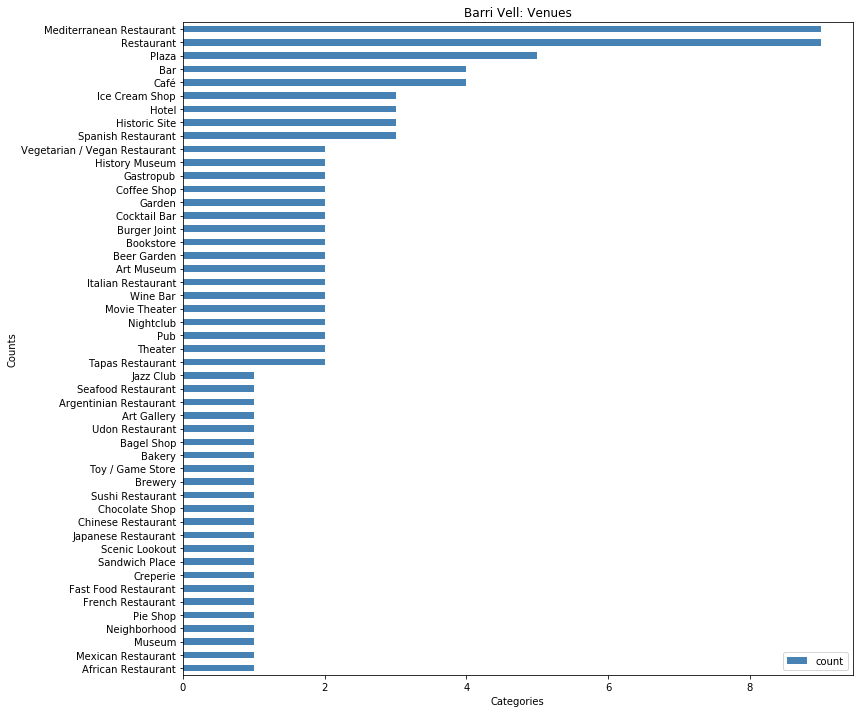

In [483]:
nearby_venues2 = nearby_venues.groupby(["categories"]).size().reset_index(name='count')

nearby_venues2 = nearby_venues2.set_index('categories')
nearby_venues2 = nearby_venues2.sort_values(by=['count'])

nearby_venues2

# step 1: get the data

# step 2: plot data
nearby_venues2.plot(kind='barh', figsize=(12, 12), color='steelblue')

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Counts') # add y-label to the plot
plt.title('Barri Vell: Venues') # add title to the plot

plt.show()